# 2D Stationary Stokes Flow on Open/Closed Channel with Tracer    

This notebook goes through two steps. 
1. solves Stokes flow injected/ejected from tank with nozzle geometry;
2. solves a convection-diffusion equation for the scalar field $u_1(x,y)$ in post-processing phase of a Stokes flow model. The convective velocity is provided by the Stokes flow model. We compare a triangular and quadrilateral mesh on channel with open and closed far end.    

<b>Problem to Solve</b> See [Stokes flow](https://en.wikipedia.org/wiki/Stokes_flow). 

<b>Goals</b>
1. compare open and closed channel;
2. compare triangular and quadrilateral mesh;

<b>Questions</b>
1. What does the pressure constraint do?
2. We would like to implement a presssure inlet condition, see e.g. [Fluent Users Guide](https://www.afs.enea.it/project/neptunius/docs/fluent/html/ug/node239.htm).
3. What is the effect of lowering the viscosity? 

<b>Remarks</b>
1. body forces have been removed; 

##  Import Packages

In [17]:
using BlockArrays
using LinearAlgebra
using UnPack
using LinearSolve 
using SparseArrays
using Ferrite
using FerriteGmsh 
using OrdinaryDiffEq
using DifferentialEquations
using Plots 
using WriteVTK

## Section 1: Introduction 

More later.

### Section 1.1: Auxiliary Functions 

In [56]:
# dof_range_u1 = dof_range(dh, :u1)
# dof_range_u2 = dof_range(dh, :u2)
# range_u1 =  unique!(reduce(vcat, [ celldofs(dh, ce)[dof_range_u1] for ce in 1:length(grid.cells) ]))
# range_u2 =  unique!(reduce(vcat, [ celldofs(dh, ce)[dof_range_u2] for ce in 1:length(grid.cells) ]))

## Section 2: Generate 2D Mesh 

In [18]:
nels  = (20, 5) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((1.0, 0.25,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

In [19]:
addvertexset!(grid, "corner", (x) -> x[1] ≈ 0.0 && x[2] ≈ 0.0)

Grid{2, Quadrilateral, Float64} with 100 Quadrilateral cells and 126 nodes

## Section 3: Functions for Assembly of Stiffness Matrix and Load Vector 
Modified tutorial by removing the volumetric source term. 

In [20]:
function assemble_flow_system!(K, dh, cvu, cvp, viscosity)
    assembler = start_assemble(K)
    ke = zeros(ndofs_per_cell(dh), ndofs_per_cell(dh))
    range_u = dof_range(dh, :u)
    ndofs_u = length(range_u)
    range_p = dof_range(dh, :p)
    ndofs_p = length(range_p)
    ϕᵤ = Vector{Vec{2,Float64}}(undef, ndofs_u)
    ∇ϕᵤ = Vector{Tensor{2,2,Float64,4}}(undef, ndofs_u) # 2-by-2 tensor 
    divϕᵤ = Vector{Float64}(undef, ndofs_u)
    ϕₚ = Vector{Float64}(undef, ndofs_p)
    for cell in CellIterator(dh)
        Ferrite.reinit!(cvu, cell)
        Ferrite.reinit!(cvp, cell)
        ke .= 0
        for qp in 1:getnquadpoints(cvu)
            dΩ = getdetJdV(cvu, qp)
            for i in 1:ndofs_u
                ϕᵤ[i] = shape_value(cvu, qp, i)
                ∇ϕᵤ[i] = shape_gradient(cvu, qp, i)
                divϕᵤ[i] = shape_divergence(cvu, qp, i)
            end
            for i in 1:ndofs_p
                ϕₚ[i] = shape_value(cvp, qp, i)
            end
            # u-u
            for (i, I) in pairs(range_u), (j, J) in pairs(range_u)
                ke[I, J] += viscosity*( ∇ϕᵤ[i] ⊡ ∇ϕᵤ[j] ) * dΩ
            end
            # u-p
            for (i, I) in pairs(range_u), (j, J) in pairs(range_p)
                ke[I, J] += ( -divϕᵤ[i] * ϕₚ[j] ) * dΩ
            end
            # p-u
            for (i, I) in pairs(range_p), (j, J) in pairs(range_u)
                ke[I, J] += ( -divϕᵤ[j] * ϕₚ[i] ) * dΩ
            end
        end
        assemble!(assembler, celldofs(cell), ke)
    end
    return K 
end

function setup_mean_constraint(dh, fvp)
    assembler = Ferrite.COOAssembler()
    # All external boundaries
    set = union(
            getfacetset(dh.grid, "left"),
            getfacetset(dh.grid, "right"),
            getfacetset(dh.grid, "bottom"),
            getfacetset(dh.grid, "top"),
    )
    # Allocate buffers
    range_p = dof_range(dh, :p)
    element_dofs = zeros(Int, ndofs_per_cell(dh))
    element_dofs_p = view(element_dofs, range_p)
    element_coords = zeros(Vec{2}, 4) # assuming 2D mesh with quadrilaterals only 
    Ce = zeros(1, length(range_p)) # Local constraint matrix (only 1 row)
    # Loop over all the boundaries
    for (ci, fi) in set
        Ce .= 0
        getcoordinates!(element_coords, dh.grid, ci)
        Ferrite.reinit!(fvp, element_coords, fi)
        celldofs!(element_dofs, dh, ci)
        for qp in 1:getnquadpoints(fvp)
            dΓ = getdetJdV(fvp, qp)
            for i in 1:getnbasefunctions(fvp)
                Ce[1, i] += shape_value(fvp, qp, i) * dΓ
            end
        end
        # Assemble to row 1
        assemble!(assembler, [1], element_dofs_p, Ce)
    end
    C, _ = finish_assemble(assembler)
    # Create an AffineConstraint from the C-matrix
    _, J, V = findnz(C)
    _, constrained_dof_idx = findmax(abs2, V)
    constrained_dof = J[constrained_dof_idx]
    V ./= V[constrained_dof_idx]
    mean_value_constraint = AffineConstraint(
        constrained_dof,
        Pair{Int,Float64}[J[i] => -V[i] for i in 1:length(J) if J[i] != constrained_dof],
        0.0,
    )

    return mean_value_constraint
end

setup_mean_constraint (generic function with 1 method)

## Section 4: Set-up, Assembly and Solve

In [54]:
nelem = 20
H = 0.25; L = 4*H 
nels  = (4*nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((L, H,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

dim = 2 
degree = 2

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 

# Dofs
dh = DofHandler(grid)
add!(dh, :u, ipu)
add!(dh, :p, ipp)
close!(dh) 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

# Boundary conditions 
ch = ConstraintHandler(dh)

vmax = 1. 
parabolic_inflow_profile(x) = Vec((4*vmax*x[2]*(H-x[2]), 0.0))

# Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
inlet = getfacetset(dh.grid, "left")
dbc1 = Dirichlet(:u, inlet, x ->  parabolic_inflow_profile(x) )
add!(ch, dbc1)

# Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
wall = union(
    getfacetset(grid, "top"),
    getfacetset(grid, "right"),
    getfacetset(grid, "bottom"),
)
dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
add!(ch, dbc2)
    
# Boundary conditions part (3/3): apply pressure constraint
mean_value_constraint = setup_mean_constraint(dh, fvp)
add!(ch, mean_value_constraint)
#dbc3 = Dirichlet(:p, inlet, (x, t) -> 0)
#add!(ch, dbc3)
    
# Finalize
close!(ch)

# Global tangent matrix and rhs
coupling = [true true; true false] # no coupling between pressure test/trial functions
K = allocate_matrix(dh, ch; coupling=coupling)
f = zeros(ndofs(dh))

# Assemble system
viscosity = 1e3
assemble_flow_system!(K, dh, cvu, cvp, viscosity); 

# Apply boundary conditions and solve
apply!(K, f, ch)
u = K \ f;

VTKGridFile("stokes_2d_channel", dh) do vtk
    write_solution(vtk, dh, u)
    Ferrite.write_constraints(vtk, ch)
end

VTKGridFile for the closed file "stokes_2d_channel.vtu".

## Section 5: Plot Velocity and Pressure by Hand-Coded Post-Processing 

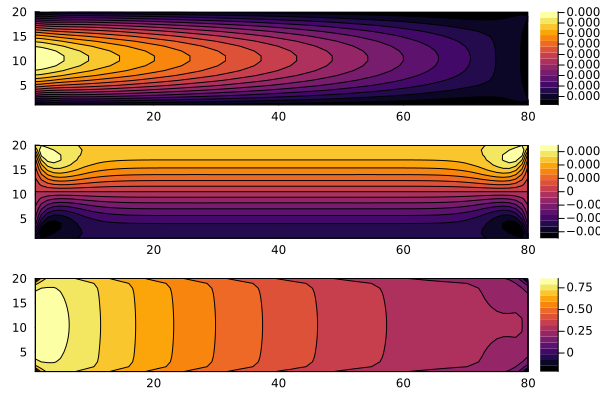

In [71]:
# assumes variable :u to be solved in previous iteration 
area = [] 
velx = [] 
vely = []
pres = []

for (cell_num, cell) in enumerate(CellIterator(dh))

    dof_range_u = dof_range(dh,:u)
    dof_range_p = dof_range(dh,:p)
    uloc = u[celldofs(dh,cell_num)[dof_range_u]]
    ploc = u[celldofs(dh,cell_num)[dof_range_p]]
    Ferrite.reinit!(cvu, cell)

    cellarea = 0. 
    cellvelocity = [0.,0.]
    cellpressure = 0 
    
    for q_point in 1:getnquadpoints(cvu)
        dΩ = getdetJdV(cvu, q_point)
        velocity = function_value(cvu, q_point, uloc)
        cellarea += dΩ 
        cellvelocity += velocity*dΩ
    end

    for q_point in 1:getnquadpoints(cvp)
        dΩ = getdetJdV(cvp, q_point)
        pressure = function_value(cvp, q_point, ploc)
        cellpressure += pressure*dΩ
    end

    append!(area, cellarea)
    append!(velx, cellvelocity[1]) 
    append!(vely, cellvelocity[2])
    append!(pres, cellpressure)
    
end

velx2d = reshape(velx, nels)
vely2d = reshape(vely, nels)
pres2d = reshape(pres, nels)
p1 = contour(velx2d', fill=true)
p2 = contour(vely2d', fill=true)
p3 = contour(pres2d', fill=true)
plot(p1,p2,p3,layout=(3,1))

## Section 6: Extend with Transport of Tracer  

In [35]:
function assemble_tracer_system!(K, dh_u1, cellvalues_u1, dh_up, cvu, pres_vel)
    assembler = start_assemble(K)
    range_u1  = dof_range(dh_u1, :u1)
    ndofs_u1  = length(range_u1)
    Ke = zeros(ndofs_u1, ndofs_u1)
    u1  = Vector{Float64}(undef, ndofs_u1)
    ∇u1 = Vector{Vec{2,Float64}}(undef, ndofs_u1)
    range_u = dof_range(dh_up, :u)
    
    for (cell_num, cell) in enumerate(CellIterator(dh_u1))

        fill!(Ke, 0)

        Ferrite.reinit!(cellvalues_u1, cell)

        vel_dof_loc = pres_vel[celldofs(dh_up,cell_num)[range_u]]
        
        for qp in 1:getnquadpoints(cellvalues_u1)
            dΩ = getdetJdV(cellvalues_u1, qp)
            for i in 1:ndofs_u1
                u1[i] = shape_value(cellvalues_u1, qp, i)
                ∇u1[i] = shape_gradient(cellvalues_u1, qp, i)
            end
            # u2-u2
            vel_loc = function_value(cvu, qp, vel_dof_loc) 
            # vel_loc[2] = 0 
            # vel_loc = [1,1]
            for (i, I) in pairs(range_u1), (j, J) in pairs(range_u1) 
                Ke[I, J] += ( ∇u1[i] ⋅ ∇u1[j] + (vel_loc ⋅ ∇u1[i] )* u1[j]) * dΩ
            end
        end 
            
        assemble!(assembler, celldofs(cell), Ke)
    end
    return K     
end

assemble_tracer_system! (generic function with 1 method)

In [24]:
nelem = 10
H = 0.25; L = 4*H 
nels  = (4*nelem, nelem) # number of elements in each spatial direction
left  = Vec((0., 0.))    # start point for geometry 
right = Vec((L, H,)) # end point for geometry
grid = generate_grid(Quadrilateral,nels,left,right);

inlet = getfacetset(dh.grid, "left")

wall = union(getfacetset(grid, "top"), getfacetset(grid, "right"), getfacetset(grid, "bottom"))

dim = 2 
degree = 1

# Interpolations
ipu = Lagrange{RefQuadrilateral,degree+1}() ^ dim # quadratic for 2 velocity components 
ipp = Lagrange{RefQuadrilateral,degree}()         # linear for scalar pressure 
ipu1 = Lagrange{RefQuadrilateral,degree+1}()      # linear for tracer 

# FE values
qr = QuadratureRule{RefQuadrilateral}(2*degree+1)
ipg = Lagrange{RefQuadrilateral,1}() # linear geometric interpolation
cvu = CellValues(qr, ipu, ipg) # observe three arguments - need to document whether this is required 
cvp = CellValues(qr, ipp, ipg) # observe three arguments - need to document whether this is required
cvu1 = CellValues(qr, ipu1, ipg) 
qr_facet = FacetQuadratureRule{RefQuadrilateral}(2)
fvp = FacetValues(qr_facet, ipp, ipg) # required for pressure constraint 

# Dofs for pressure - velocity
dh_up = DofHandler(grid)
add!(dh_up, :u, ipu)
add!(dh_up, :p, ipp)
close!(dh_up) 

# Dofs for chemistry 
dh_u1 = DofHandler(grid)
add!(dh_u1, :u1, ipu1)
close!(dh_u1)

# Boundary conditions for pressure - velocity
ch_up = ConstraintHandler(dh_up)

vmax = 1. 
parabolic_inflow_profile(x) = Vec((4*vmax*x[2]*(H-x[2]), 0.0))

# Boundary conditions part (1/3): Dirichlet BC for the velocity at the top lid 
dbc1 = Dirichlet(:u, inlet, x ->  parabolic_inflow_profile(x) )
add!(ch_up, dbc1)

# Boundary conditions part (2/3): no slip boundary condition - impose velocity to be zero vector on the walls   
dbc2 = Dirichlet(:u, wall, (x, t) -> [0, 0])
add!(ch_up, dbc2)
    
# Boundary conditions part (3/3): apply pressure constraint
mean_value_constraint = setup_mean_constraint(dh_up, fvp)
add!(ch_up, mean_value_constraint)
#dbc3 = Dirichlet(:p, inlet, (x, t) -> 0)
#add!(ch, dbc3)

# Finalize
close!(ch_up)

# Boundary conditions for pressure - velocity
ch_u1 = ConstraintHandler(dh_u1)

rho_saturated = .5
dbc4 = Dirichlet(:u1, inlet, x -> rho_saturated)
add!(ch_u1, dbc4)

# Finalize
close!(ch_u1)

# Global tangent matrix and rhs for pressure - velocity 
coupling = [true true; true false] 
K_up = allocate_matrix(dh_up, ch_up; coupling=coupling)
f_up = zeros(ndofs(dh_up)); 

# Global tangent matrix and rhs for chemistry 
K_u1 = allocate_matrix(dh_u1, ch_u1)
f_u1 = zeros(ndofs(dh_u1));

# Assemble system
viscosity = 1e3
assemble_flow_system!(K_up, dh_up, cvu, cvp, viscosity) 

# Apply boundary conditions and solve
apply!(K_up, f_up, ch_up)

u_up = K_up \ f_up  

assemble_tracer_system!(K_u1, dh_u1, cvu1, dh_up, cvu, u_up)

apply!(K_u1, f_u1, ch_u1)

u_u1 = (K_u1) \ f_u1 

VTKGridFile("stokes_2d_channel", dh_up) do vtk
    write_solution(vtk, dh_up, u_up)
    write_solution(vtk, dh_u1, u_u1)
    # Ferrite.write_constraints(vtk, ch)
end

VTKGridFile for the closed file "stokes_2d_channel.vtu".